<a href="https://colab.research.google.com/github/TNTTNTTTN/Titanic_Survive_Prediction/blob/main/term_project_code_17011266_%EC%9D%B4%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [753]:
#-*- coding: utf-8 -*-
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)

df = pd.read_csv("/content/train.csv")
stscaler = StandardScaler()
mmscaler = MinMaxScaler()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [725]:
def get_title(Name):
  if 'Mrs' in Name or 'Mme' in Name :
    Title='Mrs'
  elif 'Mr' in Name or 'Sir' in Name :
    Title='Mr'
  elif 'Miss' in Name or 'Ms' in Name or 'Mlle' in Name:
    Title='Miss'
  elif 'Master' in Name:
    Title='Master'
  else:
    Title='Else'
  return Title

In [726]:
def classify_age(Age):
  if Age<=5 : tag =0
  elif Age <=15 : tag=1
  elif Age <= 25 : tag=2
  elif Age <= 35 : tag=3
  elif Age <= 45 : tag=4
  elif Age <= 55 : tag = 5
  elif Age <= 65 : tag = 6
  else : tag = 7
  return tag

In [727]:
def classify_fare(Fare):
  if Fare <= 75 : tag=0
  elif Fare <= 150 : tag=1
  elif Fare <= 225 : tag=2
  elif Fare <= 300 : tag=3
  elif Fare <= 375 : tag=4
  elif Fare <= 450 : tag=5
  else : tag = 6
  return tag

In [728]:
df['Title'] = df['Name'].apply(lambda x : get_title(x))
df['Pclass'] = df['Pclass'].astype('string')
#title_dic = {"Mrs":0, "Mr":1, "Miss":2, "Master":3, "Else":4}
#df['Title'] = df['Title'].map(title_dic).astype(int).fillna(0)

In [729]:
#df['Sex'] = df['Sex'].map({'male':0, 'female':1}).astype(int)
df.loc[(df['Sex']=='male') & (df['Age'].isnull()) & (df['Title']==3),'Age'] = 10
df.loc[(df['Sex']=='male') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='male']['Age'].mean()
df.loc[(df['Sex']=='female') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='female']['Age'].mean()
#df['Age'] = df['Age'].apply(lambda x : classify_age(x))

In [730]:
df.loc[(df['Pclass']==1) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df.loc[(df['Pclass']==2) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df.loc[(df['Pclass']==3) & (df['Cabin'].isnull()),'Cabin'] = 'N'

In [731]:
cabin_dic={'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
df['Ncabin'] = df['Ncabin'].fillna("N")

In [732]:
df['Family'] = df['SibSp']+df['Parch']
df.loc[df['Family'] > 3,'Family'] = 4
df['Family'] = df['Family'].astype('string')

In [733]:
embark_dic = {0:"C", 1:"S", 2:"Q"}
df['Embarked'].fillna(df['Embarked'].dropna().mode()[0], inplace=True)
for i in range(3):
  df.loc[(df['Pclass']==i+1) & (df['Fare'].isnull()),'Fare'] = df[df['Pclass']==i+1]['Fare'].dropna().median()
#df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
#df['Fare'] = df['Fare'].apply(lambda x : classify_fare(x))

In [734]:
df.loc[df['Fare'].isnull(),'Fare'] = df[df['Embarked']==embark_dic[1]]['Fare'].mean()

In [735]:
df[df['Embarked']==embark_dic[1]]['Fare'].median()

13.8375

In [736]:
df[df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ncabin,Family


In [737]:
df['Sex'].value_counts()

male      266
female    152
Name: Sex, dtype: int64

ValueError: ignored

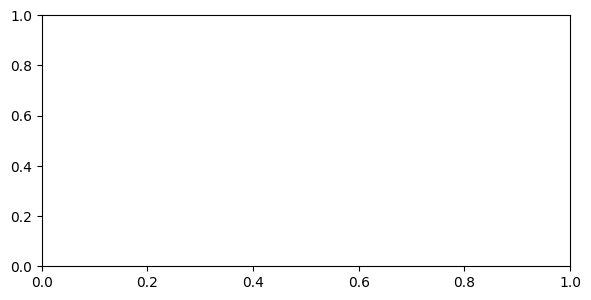

In [738]:
plt.figure(figsize=(15,15))
plt.subplot(4,2,1)
sns.barplot(x='Pclass', y='Survived', data=df)
plt.subplot(4,2,2)
sns.kdeplot(x='Fare', hue='Survived', data=df)
plt.subplot(4,2,3)
sns.barplot(x='Title', y='Survived', data=df)
plt.subplot(4,2,4)
sns.barplot(x='Family', y='Survived', data=df)
plt.subplot(4,2,5)
sns.barplot(x='Embarked', y='Survived', data=df)
plt.subplot(4,2,6)
sns.kdeplot(x='Age', hue='Survived', data=df)

In [739]:
df.drop(['PassengerId','Name', 'Cabin', 'Ticket', 'SibSp','Parch'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    string 
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   Fare      418 non-null    float64
 4   Embarked  418 non-null    object 
 5   Title     418 non-null    object 
 6   Ncabin    418 non-null    object 
 7   Family    418 non-null    string 
dtypes: float64(2), object(4), string(2)
memory usage: 26.2+ KB


In [740]:
stscaler.fit(df[['Age','Fare']])
scaled = stscaler.transform(df[['Age','Fare']])
mmscaler.fit(scaled)
output = mmscaler.transform(scaled)
output = pd.DataFrame(output, columns=['Age','Fare'])
df['Age'] = output['Age']
df['Fare'] = output['Fare']
#df['Ncabin'] = df['Ncabin'].astype(int)

In [741]:
#Survive = df.iloc[:,0]
#df = pd.get_dummies(df.iloc[:,1:])
df = pd.get_dummies(df)
#df = pd.concat([Survive, df],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           418 non-null    float64
 1   Fare          418 non-null    float64
 2   Pclass_1      418 non-null    uint8  
 3   Pclass_2      418 non-null    uint8  
 4   Pclass_3      418 non-null    uint8  
 5   Sex_female    418 non-null    uint8  
 6   Sex_male      418 non-null    uint8  
 7   Embarked_C    418 non-null    uint8  
 8   Embarked_Q    418 non-null    uint8  
 9   Embarked_S    418 non-null    uint8  
 10  Title_Else    418 non-null    uint8  
 11  Title_Master  418 non-null    uint8  
 12  Title_Miss    418 non-null    uint8  
 13  Title_Mr      418 non-null    uint8  
 14  Title_Mrs     418 non-null    uint8  
 15  Ncabin_A      418 non-null    uint8  
 16  Ncabin_B      418 non-null    uint8  
 17  Ncabin_C      418 non-null    uint8  
 18  Ncabin_D      418 non-null    

In [742]:
dataset = df.values
X = dataset[:,1:]
Y = dataset[:,0]
n_fold = 10
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=3)
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
accuracy =[]

In [721]:
model = Sequential()
model.add(Dense(16, input_dim=28, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='loss', patience=25)
#history = model.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#          callbacks=[early_stopping_callback])
#model.fit(X, Y, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#         callbacks=[early_stopping_callback])
for train, test in skf.split(X, Y):
    model.fit(X[train], Y[train], epochs=250, batch_size=5, callbacks=[early_stopping_callback])
    k_accuracy = "%.4f" % (model.evaluate(X[test], Y[test])[1])
    accuracy.append(k_accuracy)
print("\n %.f fold accuracy:" % n_fold, accuracy)

Epoch 1/250
161/161 [==============================] - 1s 2ms/step - loss: 0.6386 - accuracy: 0.6105
Epoch 2/250
161/161 [==============================] - 0s 2ms/step - loss: 0.5557 - accuracy: 0.7366
Epoch 3/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4992 - accuracy: 0.7903
Epoch 4/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4955 - accuracy: 0.7640
Epoch 5/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4547 - accuracy: 0.8052
Epoch 6/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.8102
Epoch 7/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4569 - accuracy: 0.8090
Epoch 8/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4524 - accuracy: 0.8090
Epoch 9/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.8202
Epoch 10/250
161/161 [==============================] - 0s 2ms/step - loss: 0.4304 - accura

In [722]:
model.fit(X, Y, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
         callbacks=[early_stopping_callback])

Epoch 1/1000
143/143 [==============================] - 0s 3ms/step - loss: 0.3393 - accuracy: 0.8455 - val_loss: 0.2408 - val_accuracy: 0.8994
Epoch 2/1000
143/143 [==============================] - 0s 3ms/step - loss: 0.3397 - accuracy: 0.8539 - val_loss: 0.2439 - val_accuracy: 0.8939
Epoch 3/1000
143/143 [==============================] - 1s 4ms/step - loss: 0.3368 - accuracy: 0.8638 - val_loss: 0.2472 - val_accuracy: 0.8994
Epoch 4/1000
143/143 [==============================] - 0s 3ms/step - loss: 0.3416 - accuracy: 0.8624 - val_loss: 0.2464 - val_accuracy: 0.8994
Epoch 5/1000
143/143 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.8680 - val_loss: 0.2441 - val_accuracy: 0.8994
Epoch 6/1000
143/143 [==============================] - 0s 3ms/step - loss: 0.3292 - accuracy: 0.8652 - val_loss: 0.2359 - val_accuracy: 0.8994
Epoch 7/1000
143/143 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8610 - val_loss: 0.2384 - val_accuracy:

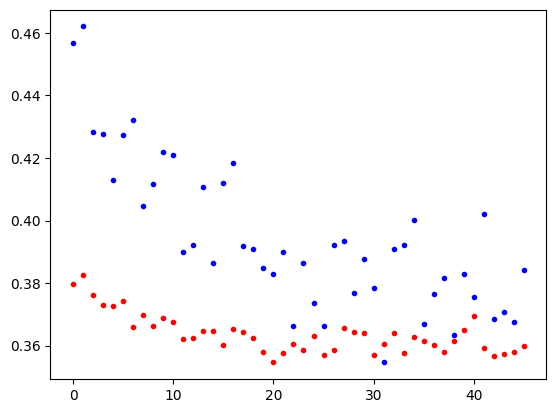

9/9 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7873

 Accurarcy: 0.7873


In [607]:
model_vloss = history.history['val_loss'][10:]
model_loss = history.history['loss'][10:]
x_len = np.arange(len(model_loss))

plt.plot(x_len, model_vloss, "o", c="red", markersize=3)
plt.plot(x_len, model_loss, "o", c="blue", markersize=3)
plt.show()

print("\n Accurarcy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

In [723]:
model.save('please5.h5')

In [743]:
model = load_model('please5.h5')
Y_prediction = model.predict(dataset).flatten()




14/14 [==============================] - 0s 2ms/step


In [217]:
Y_prediction

array([0.11722659, 0.40866733, 0.13681594, 0.11251757, 0.5664738 ,
       0.11374838, 0.6900107 , 0.13988177, 0.60747606, 0.11481825,
       0.11223755, 0.2993596 , 0.96575564, 0.11716014, 0.963159  ,
       0.94531775, 0.15359524, 0.11568338, 0.454807  , 0.50810957,
       0.30347264, 0.7426298 , 0.9649131 , 0.3965918 , 0.8919366 ,
       0.10958512, 0.9665996 , 0.11549427, 0.3123818 , 0.11667348,
       0.11949418, 0.1411181 , 0.8775627 , 0.8841701 , 0.37016112,
       0.11600801, 0.48376757, 0.51951987, 0.11269774, 0.11256566,
       0.11179957, 0.3391412 , 0.11141827, 0.9330158 , 0.9633191 ,
       0.11268675, 0.34858996, 0.11787211, 0.9637603 , 0.52047   ,
       0.33442774, 0.1406264 , 0.96536756, 0.89758927, 0.13889834,
       0.22128342, 0.11186187, 0.11268483, 0.11072077, 0.9668859 ,
       0.11343455, 0.12869248, 0.11333522, 0.7248919 , 0.95674264,
       0.9333967 , 0.74190456, 0.2997353 , 0.38561237, 0.8127237 ,
       0.7162895 , 0.11304995, 0.4885076 , 0.39224643, 0.96671

In [744]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = Y_prediction
submission.loc[submission['Survived'] < 0.5 ,'Survived'] = 0
submission.loc[submission['Survived'] >= 0.5 ,'Survived'] = 1
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('submit3.csv',index=False)

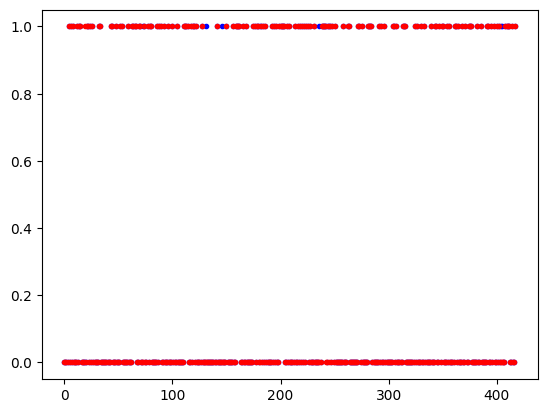

In [506]:
#Y_prediction = model.predict(X_test).flatten()
osub = pd.read_csv("submit.csv")

Y_pred_old = osub['Survived']

#plt.plot(range(len(Y_test)), Y_test, "o", c="red", markersize=3)
plt.plot(range(len(Y_prediction)), submission['Survived'], "o", c="blue", markersize=3)
plt.plot(range(len(Y_prediction)), Y_pred_old, "o", c='red', markersize=3)
plt.show()

In [21]:
t = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.DataFrame(t).value_counts()

KeyError: ignored

In [ ]:
df['FBand'] = pd.cut(df['Fare'], 7)
df[['FBand','Survived']].groupby(['FBand'], as_index=False).mean()

In [ ]:
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
pd.crosstab(df['Ncabin'],df['Survived'])

In [ ]:
df[['Embarked','Fare']].groupby(['Embarked'], as_index=False).mean()
df[['Pclass','Fare']].groupby(['Pclass'], as_index=False).mean()

In [ ]:
df.info()
df[df['Embarked'].isnull()]

In [ ]:

df[['Ncabin','Survived']].groupby('Ncabin').mean()

In [751]:
submit1 = pd.read_csv('submit.csv')
submit2 = pd.read_csv('submit3.csv')

In [752]:
submit1[submit1['Survived'] == submit2['Survived']]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
